In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


 ## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import ttest_ind, ks_2samp
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 ## Importing dataset

In [0]:
dataset = pd.read_csv('creditcard.csv')

 ## View information about the dataset.

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


 ## Data Visualization

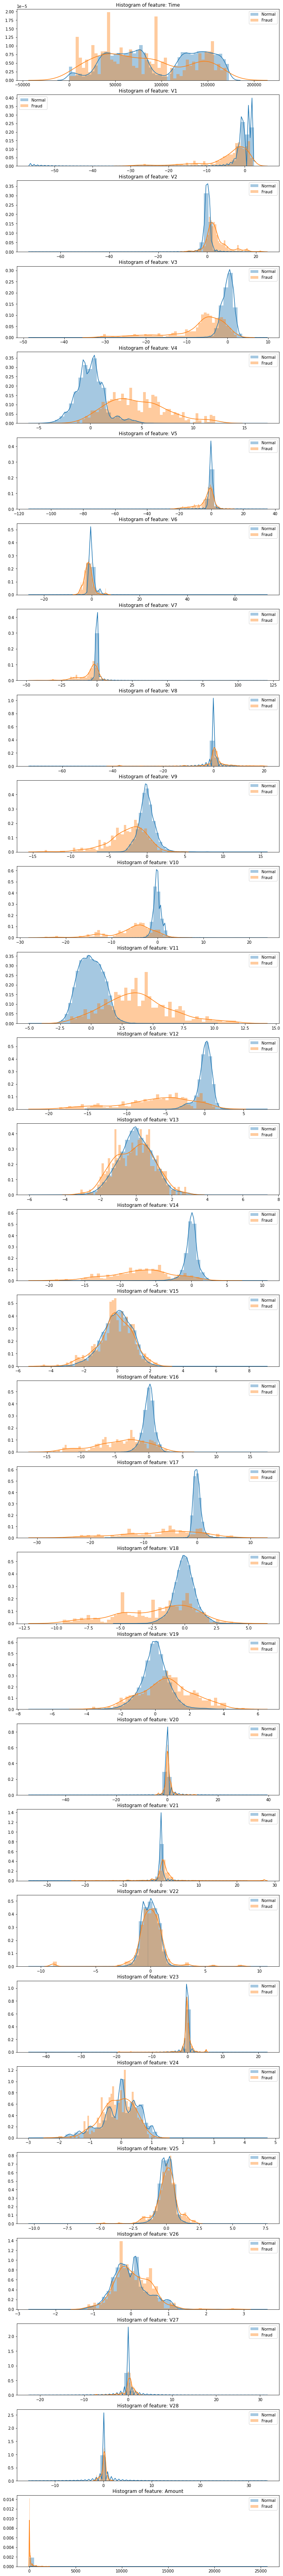

In [9]:
# Select the features
v_features = dataset.iloc[:, 0:30].columns

plt.figure(figsize = (12, 120))
gs = gridspec.GridSpec(30, 1)
for i, cn in enumerate(dataset[v_features]):
    ax = plt.subplot(gs[i])    
    sns.distplot(dataset[cn][dataset.Class == 0], bins = 50, label = 'Normal')
    sns.distplot(dataset[cn][dataset.Class == 1], bins = 50, label = 'Fraud')
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
    plt.legend()
plt.show()

## Splitting the dataset into the Training set and Test set

將資料集分割成訓練集與測試集，前70%的部分為訓練集，後30%的部分為測試集，在訓練集上建模後使用測試集做驗證。

In [10]:
from sklearn.model_selection import train_test_split
def split_data(dataset):    
    train, test = train_test_split(dataset, test_size = 0.3, shuffle = False)
    print('train-set size: ', len(train), 
          '\ntest-set size: ', len(test))
    return train, test
train_set, test_set = split_data(dataset)

train-set size:  199364 
test-set size:  85443


In [11]:
print('Fraud cases in train-set:', train_set['Class'].sum(), 
      '\nFraud cases in test-set:', test_set['Class'].sum())

Fraud cases in train-set: 384 
Fraud cases in test-set: 108


## Feature selection

### Two-Sample T Test

In [0]:
# Plot statistic sorted by p_value
def plot_test_statistic(result):
    tmp = result.sort_values(by = 'p_value')
    tmp.Statistic = tmp.Statistic.abs()
    plt.figure(figsize = (8, 15))
    plt.title('Feature with Test Statistics', fontsize = 14)
    s = sns.barplot(x = 'Statistic', y = 'Feature', data = tmp)
    s.set_yticklabels(s.get_yticklabels(), rotation = 0)
    plt.show()

In [0]:
# Two-Sample T test for each features
columns = train_set.columns[0:30]
T_statistic = []
p_values = []
for ii in range(30):
    group0 = train_set[train_set['Class'] == 0][columns[ii]]
    group1 = train_set[train_set['Class'] == 1][columns[ii]]
    statistic, p_value = ttest_ind(group0, group1, equal_var = False)
    T_statistic.append(statistic)
    p_values.append(p_value)
t_test_result = pd.DataFrame({'Feature': columns, 
                              'Statistic': T_statistic, 
                              'p_value': p_values})

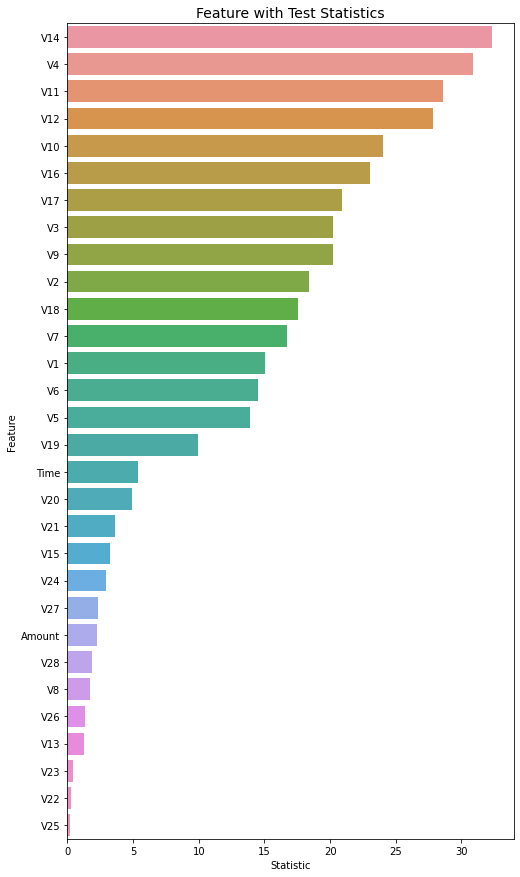

In [14]:
plot_test_statistic(result = t_test_result)

### Two-Sample K-S test

In [0]:
# Two-Sample k-s test for each features
columns = train_set.columns[0:30]
D_statistic = []
p_values = []
for ii in range(30):
    group0 = train_set[train_set['Class'] == 0][columns[ii]]
    group1 = train_set[train_set['Class'] == 1][columns[ii]]
    statistic, p_value = ks_2samp(group0, group1)
    D_statistic.append(statistic)
    p_values.append(p_value)
ks_test_result = pd.DataFrame({'Feature': columns, 
                               'Statistic': D_statistic, 
                               'p_value': p_values})

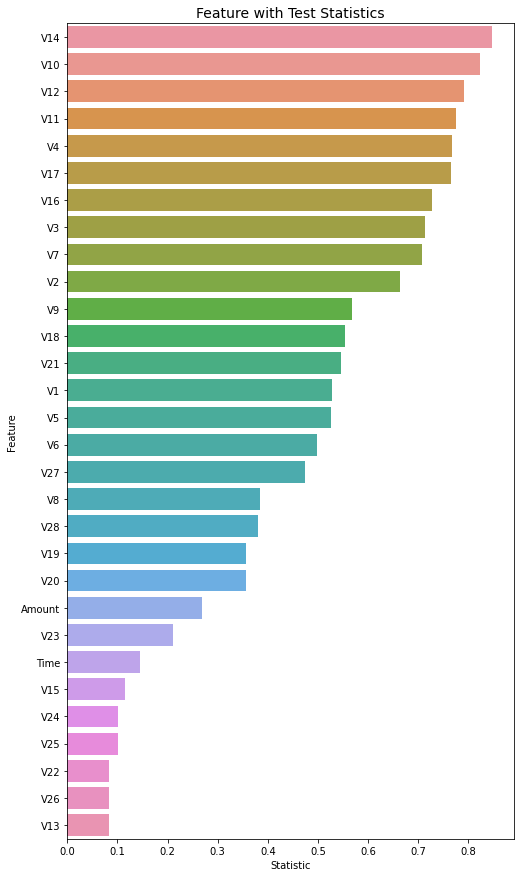

In [16]:
plot_test_statistic(result = ks_test_result)

In [17]:
t_test_result.sort_values(by = 'p_value').Feature[0:30].values

array(['V14', 'V4', 'V11', 'V12', 'V10', 'V16', 'V17', 'V3', 'V9', 'V2',
       'V18', 'V7', 'V1', 'V6', 'V5', 'V19', 'Time', 'V20', 'V21', 'V15',
       'V24', 'V27', 'Amount', 'V28', 'V8', 'V26', 'V13', 'V23', 'V22',
       'V25'], dtype=object)

In [18]:
ks_test_result.sort_values(by = 'p_value').Feature[0:30].values

array(['V14', 'V10', 'V12', 'V11', 'V4', 'V17', 'V16', 'V3', 'V7', 'V2',
       'V9', 'V18', 'V21', 'V1', 'V5', 'V6', 'V27', 'V8', 'V28', 'V19',
       'V20', 'Amount', 'V23', 'Time', 'V15', 'V24', 'V25', 'V22', 'V26',
       'V13'], dtype=object)

 ## Select columns by K-S test

In [0]:
# select features by ks_test
select_list = ks_test_result.sort_values(by = 'p_value').Feature[0:30].values

In [0]:
X_train = train_set.drop(['Class'], axis = 1)
y_train = train_set['Class']
X_test = test_set.drop(['Class'], axis = 1)
y_test = test_set['Class']

In [0]:
X_train = X_train[select_list[0:4]].values
X_test = X_test[select_list[0:4]].values
y_train = y_train.values
y_test = y_test.values

In [24]:
# Drop features
'''
drop_list = ['Time', 'Amount']
X_train = X_train.drop(drop_list, axis = 1).values
X_test = X_test.drop(drop_list, axis = 1).values
y_train = y_train.values
y_test = y_test.values
'''

"\ndrop_list = ['Time', 'Amount']\nX_train = X_train.drop(drop_list, axis = 1).values\nX_test = X_test.drop(drop_list, axis = 1).values\ny_train = y_train.values\ny_test = y_test.values\n"

## Fitting the classifier to the Training set: Logistic Regression

In [25]:
lr_clf = LogisticRegression(solver = 'liblinear', random_state = 0)
lr_clf.fit(X_train, y_train)
y_score = lr_clf.predict_proba(X_test)[:, 1]
y_pred = lr_clf.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

print('Accuracy = {}'.format(Accuracy))
print('Precision = {}'.format(Precision))
print('Recall = {}'.format(Recall))
print('F1 score = {}'.format(F1_score))
print('ROC_AUC = {}'.format(roc_auc))
print('Average Precision = {}'.format(average_precision))

Accuracy = 0.9992860737567735
Precision = 0.9607843137254902
Recall = 0.4537037037037037
F1 score = 0.6163522012578616
ROC_AUC = 0.9348588026709548
Average Precision = 0.7026760684028032


## Add features by ks_test_result

In [0]:
y_train = train_set['Class'].values
y_test = test_set['Class'].values
train_accuracy = []
train_f1 = []
train_precision = []
train_recall = []
train_roc_auc = []
train_pr_auc = []

test_accuracy = []
test_f1 = []
test_precision = []
test_recall = []
test_roc_auc = []
test_pr_auc = []

for ii in range(1, 31):
    # Reset dataset
    X_train = train_set.drop(['Class'], axis = 1)    
    X_test = test_set.drop(['Class'], axis = 1)
    
    # Select 0 to ii-1 features
    X_train = X_train[select_list[0:ii]].values
    X_test = X_test[select_list[0:ii]].values

    # Logistic Regression
    lr_clf = LogisticRegression(solver = 'liblinear', random_state = 0)
    lr_clf.fit(X_train, y_train)

    # train predict score
    y_train_score = lr_clf.predict_proba(X_train)[:, 1]
    y_train_pred = lr_clf.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    train_precision.append(precision_score(y_train, y_train_pred))
    train_recall.append(recall_score(y_train, y_train_pred))
    train_roc_auc.append(roc_auc_score(y_train, y_train_score))
    train_pr_auc.append(average_precision_score(y_train, y_train_score))

    # test predict score
    y_test_score = lr_clf.predict_proba(X_test)[:, 1]
    y_test_pred = lr_clf.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    test_f1.append(f1_score(y_test, y_test_pred))
    test_precision.append(precision_score(y_test, y_test_pred))
    test_recall.append(recall_score(y_test, y_test_pred))
    test_roc_auc.append(roc_auc_score(y_test, y_test_score))
    test_pr_auc.append(average_precision_score(y_test, y_test_score))

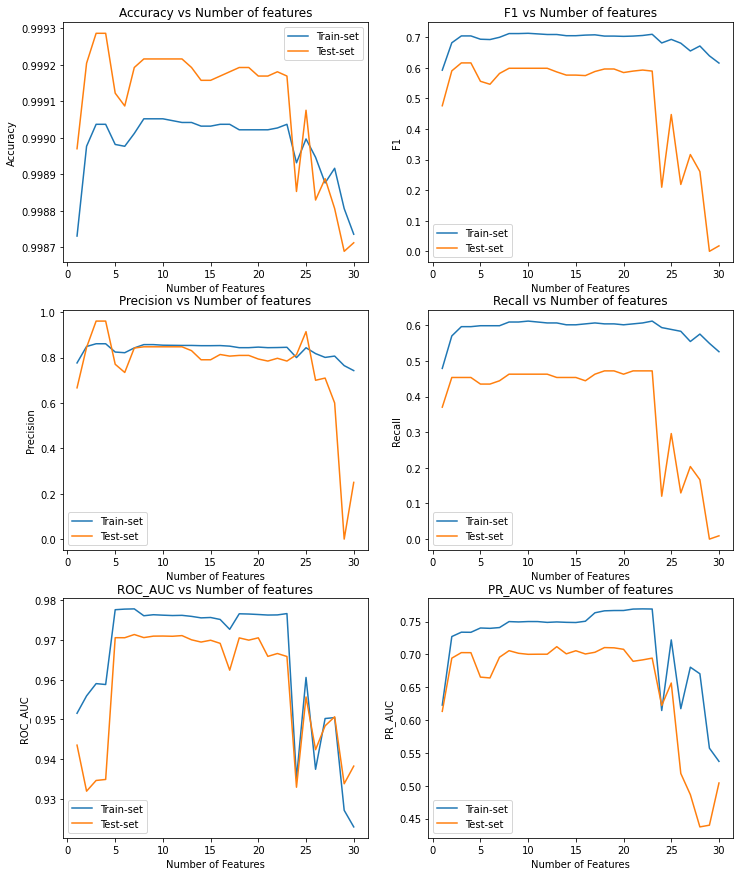

In [27]:
# Plot figures
plt.figure(figsize = (12, 15))

# Accuracy
plt.subplot(3, 2, 1)
plt.title('Accuracy vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.plot(range(1, 31), train_accuracy, '-', label = 'Train-set')
plt.plot(range(1, 31), test_accuracy, '-', label = 'Test-set')
plt.legend()

# F1
plt.subplot(3, 2, 2)
plt.title('F1 vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('F1')
plt.plot(range(1, 31), train_f1, '-', label = 'Train-set')
plt.plot(range(1, 31), test_f1, '-', label = 'Test-set')
plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.title('Precision vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('Precision')
plt.plot(range(1, 31), train_precision, '-', label = 'Train-set')
plt.plot(range(1, 31), test_precision, '-', label = 'Test-set')
plt.legend()

# Recall
plt.subplot(3, 2, 4)
plt.title('Recall vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.plot(range(1, 31), train_recall, '-', label = 'Train-set')
plt.plot(range(1, 31), test_recall, '-', label = 'Test-set')
plt.legend()

# ROC_AUC
plt.subplot(3, 2, 5)
plt.title('ROC_AUC vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('ROC_AUC')
plt.plot(range(1, 31), train_roc_auc, '-', label = 'Train-set')
plt.plot(range(1, 31), test_roc_auc, '-', label = 'Test-set')
plt.legend()

# PR_AUC
plt.subplot(3, 2, 6)
plt.title('PR_AUC vs Number of features')
plt.xlabel('Number of Features')
plt.ylabel('PR_AUC')
plt.plot(range(1, 31), train_pr_auc, '-', label = 'Train-set')
plt.plot(range(1, 31), test_pr_auc, '-', label = 'Test-set')
plt.legend()

plt.show()